## SQL Chinook db

Chinook is a fictitious database of songs purchased online similar to iTunes. We will be worknig with 11 tables and retrieving required information using SQL select statements.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3 
%matplotlib inline

In [2]:
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)

In [3]:
def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)

In [4]:
def show_tables():
    return run_query("""
SELECT
    name,
    type
FROM sqlite_master
WHERE type IN ("table","view");""")

In [5]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


In [6]:
q="""
WITH us_customers AS (
SELECT c.country, i.customer_id, i.invoice_id, IL.TRACK_ID 
FROM customer c INNER JOIN invoice i on c.customer_id=i.customer_id
INNER JOIN invoice_line il on il.invoice_id=i.invoice_id
WHERE c.country="USA"),
genres AS (
SELECT g.name genre, t.track_id
FROM genre g INNER JOIN track t ON g.genre_id=t.genre_id 
)
SELECT  g.genre, count(*) total from us_customers uc INNER JOIN genres g ON
uc.track_id=g.track_id group by 1 order by 2 desc limit 10;

"""
top_genres_us = run_query(q)
run_query(q)

,genre,total
0,Rock,561
1,Alternative & Punk,130
2,Metal,124
3,R&B/Soul,53
4,Blues,36
5,Alternative,35
6,Latin,22
7,Pop,22
8,Hip Hop/Rap,20
9,Jazz,14


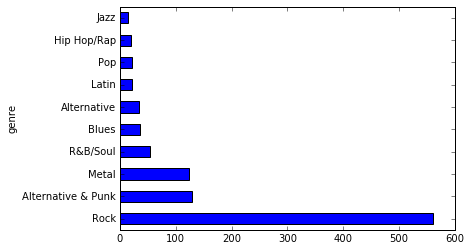

In [7]:
top_genres_us.set_index('genre').plot(kind='barh', legend=False)

According to the dataset, most purchased songs belong to Rock, Alternative&Punk and Metal genres.

In [8]:
q = """
WITH emp_cus AS (
select e.employee_id, e.first_name || " " || e.last_name name, e.title, c.customer_id 
FROM employee AS e INNER JOIN customer c ON e.employee_id=c.support_rep_id
)
Select e.name, e.title, sum(i.total) total from emp_cus e inner join invoice i ON e.customer_id=i.customer_id
Group by 1;
"""
run_query(q)

,name,title,total
0,Jane Peacock,Sales Support Agent,1731.51
1,Margaret Park,Sales Support Agent,1584.00
2,Steve Johnson,Sales Support Agent,1393.92


3 employees performed most of the sales over 1000$. 

In [34]:
c = '''
With  cust_sales AS (
    SELECT COUNT(distinct(c.customer_id)) n_cust, COUNT(distinct(i.invoice_id)) tot_order, c.first_name, C.COUNTRY, sum(i.total) sales from customer c 
    LEFT JOIN invoice i ON c.customer_id=i.customer_id 
    GROUP BY c.country ),
 ctr as (
SELECT ctr, n_cust total_customers, sales, tot_order 
from (
    select *,
    CASE 
        WHEN n_cust = 1 THEN  "Other"
        ELSE country
    END as ctr
    from cust_sales
))
Select ctr country, sum(total_customers) total_customers, sum(sales) total_sales, avg(sales/tot_order) avg_order,  avg(sales/total_customers) avg_sales   from ctr group by ctr order by sales desc
;
'''
run_query(c)

,country,total_customers,total_sales,avg_order,avg_sales
0,USA,13,1040.49,7.942672,80.037692
1,Canada,8,535.59,7.047237,66.948750
2,Brazil,5,427.68,7.011148,85.536000
3,France,5,389.07,7.781400,77.814000
4,Germany,4,334.62,8.161463,83.655000
5,Czech Republic,2,273.24,9.108000,136.620000
6,United Kingdom,3,245.52,8.768571,81.840000
7,Portugal,2,185.13,6.383793,92.565000
8,India,2,183.15,8.721429,91.575000
9,Other,15,1094.94,7.445071,72.996000


In [35]:
sales_data = run_query(c)

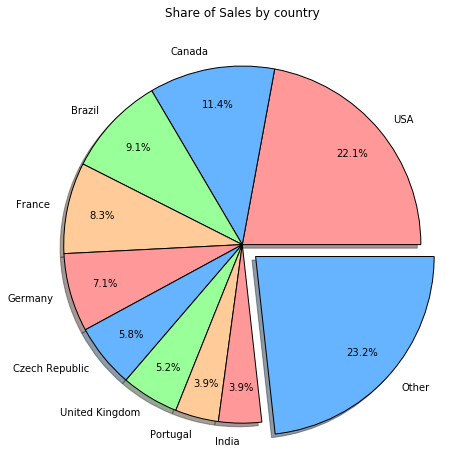

In [55]:
plt.figure(figsize=(16,8))
ax1 = plt.subplot(aspect='equal')
color = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
expld = np.zeros(10)
expld[9]=0.1
sales_data.set_index('country').plot(kind='pie', y="total_sales", ax=ax1, legend=False, explode=expld, autopct='%1.1f%%', pctdistance=0.8 , shadow=True, colors = color)
plt.title("Share of Sales by country")
plt.ylabel("")

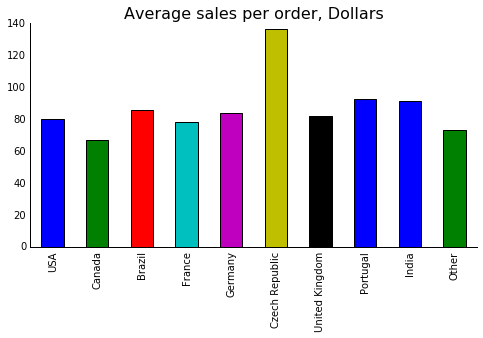

In [75]:
plt.figure(figsize=(8,4))
ax1 = plt.subplot()
sales_data.set_index("country").plot(kind='bar', y='avg_sales', legend=False, ax=ax1)
plt.tick_params(bottom='off', top='off', left='off', right='off')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
plt.title("Average sales per order, Dollars", fontsize=16)
plt.xlabel("")

In [92]:
#Q Write a query that categorizes each invoice as either an album purchase or not, and calculates the following summary statistics: Number of invoices Percentage of invoices
q="""
WITH albums AS (
SELECT a.album_id, t.album_id, t.track_id from album a left join track t on a.album_id=t.album_id),
purchases AS (
SELECT t.album_id, i.customer_id, il.invoice_id, t.track_id from invoice_line il inner join invoice i on i.invoice_id=il.invoice_id inner join track t on il.track_id=t.track_id 
)
select * from albums a left join purchases p on a.track_id=p.track_id
"""
# coming soon